# ML Models
K-nn, linear and logistic regression, decision trees

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, log_loss

from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge
from sklearn.tree import DecisionTreeClassifier,export_text, DecisionTreeRegressor

from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor

from mlxtend.plotting import plot_decision_regions

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, f_regression

import warnings
warnings.simplefilter("ignore")

# Skin of orange data

In [2]:
sample_size=80
np.random.seed(seed=1234)
skin=pd.DataFrame(np.random.uniform(size=(sample_size,20)))
skin['G']=skin[1]>1/2
skin_test=pd.DataFrame(np.random.uniform(size=(80,20)))
skin_test['G']=skin_test[1]>1/2


In [3]:
#skin.to_csv('data/skin.csv')
#skin_test.to_csv('data/skin_test.csv')
skin=pd.read_csv('data/skin.csv')
skin_test=pd.read_csv('data/skin_test.csv')

# Train test split

In [4]:
data=skin
X, y = (data.iloc[:,:-1], data.iloc[:,-1])
X_train0, X_test0, y_train, y_test = train_test_split(X, y, random_state=0)
print('Train {}, Test {}'.format(len(y_train),len(y_test)))

Train 60, Test 20


## Feature selection, standardization only on Train data

Transform the test data

In [5]:
number_features=2
preproc=SelectKBest(f_classif, k=number_features)
X_train = preproc.fit_transform(X_train0,  y_train)

scores=pd.DataFrame({'column':X_train0.columns,'score':preproc.scores_})
X_train=pd.DataFrame(X_train, columns=scores.sort_values(by=['score'],ascending=False)[:number_features]['column'])
X_test = pd.DataFrame(preproc.transform(X_test0), columns=scores.sort_values(by=['score'],ascending=False)[:number_features]['column'])
X_train.columns

Index(['1', '4'], dtype='object', name='column')

## Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(penalty='l2')
lr.fit(X_train,y_train)

print('Test accurancy: {}'.format(lr.score(X_test,y_test)))
cv_score=cross_val_score(lr,X_train , y_train, cv=10)
cv_score

Test accurancy: 0.9


array([0.83333333, 1.        , 1.        , 0.83333333, 1.        ,
       1.        , 0.83333333, 1.        , 0.83333333, 0.83333333])

In [7]:
(lr.intercept_,lr.coef_)

(array([-1.66969866]), array([[3.43914646, 0.96340696]]))

## k Nearest Neighbours

error estimates for different `k`

In [8]:
k=5
for k in [1,5,10,40]:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)    
    print(f"{k}-neighbours: error={np.mean(~clf.predict(X_test)==y_test):4.2f}") # incorrect predictions/N

1-neighbours: error=0.10
5-neighbours: error=0.15
10-neighbours: error=0.15
40-neighbours: error=0.30


## Plot decision regions

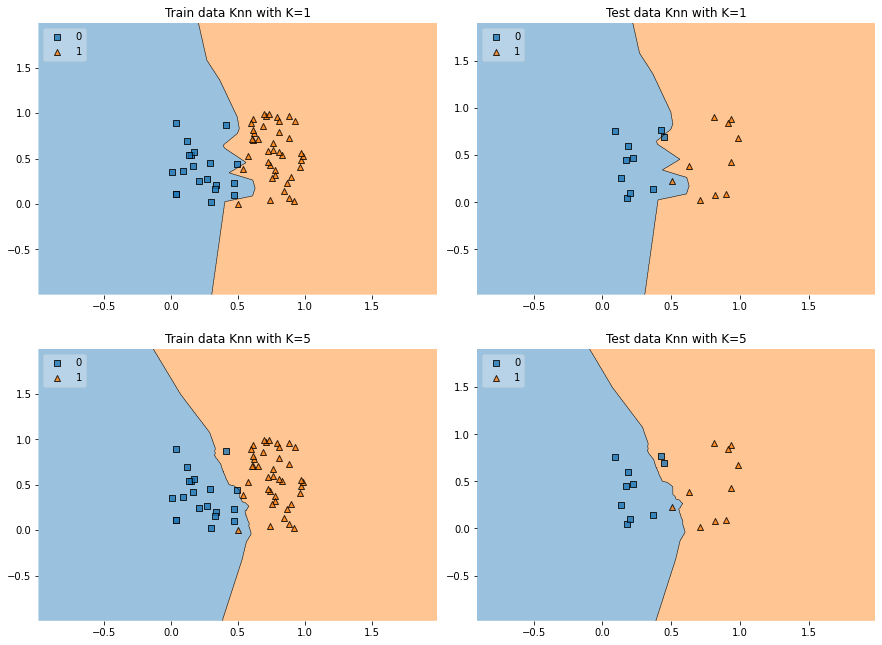

In [9]:
fig, ax_lst = plt.subplots(2, 2,figsize=(15,11)) 
fig.subplots_adjust(hspace=0.2, wspace=0.1)
for (i,k) in [(1,1),(3,5)]:
    sub1=plt.subplot(2,2,i)
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)                        ################### fit
    plot_decision_regions(X_train.values, y_train.astype('int').values, clf=clf, legend=2) ######### train data plot
    plt.title('Train data Knn with K={}'.format(k))
    sub1=plt.subplot(2,2,i+1)
    plot_decision_regions(X_test.values, y_test.astype('int').values, clf=clf, legend=2)  ########## test data plot, clf for background as before
    plt.title('Test data Knn with K={}'.format(k))
plt.show()

## Bias variance tradeoff

In [10]:
num_trials=20
best_features=10
sample_size=80
np.random.seed(seed=1234)

results=pd.DataFrame(columns=['k','bias','variance'])
columns=['X{}'.format(i) for i in range(20)]
pred_cols=['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10',
       'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19']
col_names=columns

test_data=pd.DataFrame(np.random.uniform(size=(sample_size,20)),columns=columns)
for k in [1,2,3,4,5,6,7,8,9,10,20,50]:
    test_df=test_data.copy()
    for trial in range(num_trials):
        sample_data=pd.DataFrame(np.random.uniform(size=(sample_size,20)),columns=columns)
        y_train=sample_data['X1']>1/2

        if k==0:
            test_df['P{}'.format(trial)]=np.mean(y_train)
        else:
            preproc=SelectKBest(f_regression, k=best_features)
#            X_train = preproc.fit_transform(sample_data,  y_train)
#            scores=pd.DataFrame({'column':sample_data.columns,'score':preproc.scores_})
#            col_names=scores.sort_values(by=['score'],ascending=False)[:k]['column']

            clf = KNeighborsRegressor(n_neighbors=k)
            clf.fit(sample_data[col_names], y_train)    
            test_df['P{}'.format(trial)]=clf.predict(test_data[col_names])

    test_df['Ef']=test_df[pred_cols].mean(axis=1)
    test_df['Y']=test_df['X1']>1/2 

    results=pd.concat([results, pd.DataFrame({'k':[k],
                                              'bias':[(np.mean(np.abs(test_df['Ef']-test_df['Y'])))], 
                                              'variance':[np.mean((test_df[pred_cols].apply(lambda x: (x-test_df['Ef']),axis=0)).var(axis=0))]
                                             })])
    

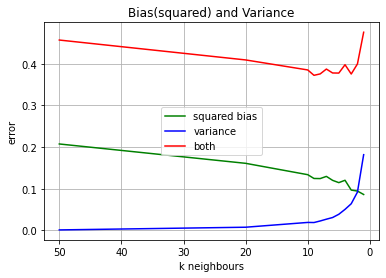

In [11]:
plt.plot(results.k, results.bias*results.bias,  color='green',label='squared bias')
plt.plot(results.k, results.variance, color='blue',label='variance')
plt.plot(results.k, results.variance+results.bias,color='red', label='both')

plt.legend()
plt.title('Bias(squared) and Variance')
# grab a reference to the current axes
ax = plt.gca()
# set the xlimits to be the reverse of the current xlimits
ax.set_xlim(ax.get_xlim()[::-1])
# call `draw` to re-render the graph
plt.ylabel('error')
plt.xlabel('k neighbours')
plt.grid()
plt.draw()


In [12]:
results['err']=results.variance+results.bias*results.bias
results['bias^2']=results.bias*results.bias
results.sort_values(by=['err'],ascending=True)#.iloc[0]

k      bias  variance       err    bias^2
0   9  0.353194  0.019024  0.143770  0.124746
0   8  0.352813  0.022756  0.147232  0.124477
0   6  0.346771  0.031052  0.151302  0.120250
0  10  0.365812  0.019274  0.153092  0.133819
0   5  0.338750  0.038844  0.153595  0.114752
0   7  0.360179  0.027032  0.156761  0.129729
0   3  0.311250  0.064101  0.160977  0.096877
0  20  0.401344  0.007778  0.168855  0.161077
0   4  0.347031  0.050606  0.171037  0.120431
0   2  0.307500  0.092017  0.186574  0.094556
0  50  0.455525  0.001315  0.208818  0.207503
0   1  0.293750  0.181797  0.268087  0.086289

In [13]:
1/(12*60)

0.001388888888888889